## Capstone Project Battle of the Neighbourhoods - Week4

#### Problem
Description: An International NPO is looking to donate money and upgrade a Tradeschool in Cape Town. 
Once students are trained they will have the skills to start their own business and manufacture their own goods to sell at flea markets. The skills that will be taught is Carpentry, Electrician, Ironworker, Plumber and Welder. The impact the NPO wants to make is aleviate poverty and unemployment in the City. In addition they will also be setting up pyrolysis plants to turn plastic into fuel, this needs to be done to make the Tradeschool project more sustainable.


### Data description
I will be looking at the Cost of living for 3 Cities first, so there can be an idea of how different the costs are in cities located in devoloped countries vs a city in a developing country, this data I will obtain from from www.expatistan.com and various other sources. I will use the foursquare API to map the locations of Tradeschools, Recycling Places (Pyrolysis plants needs to be closed to these), Home Services and Fleamarkets in Cape Town to see if it will be a viable proposal for to have a tradeschool in the city and see if it is possible to get the data for some settlements such as the Highest education levels and place that on the map as well. The link to the project on github is https://github.com/pieterdt1979/coursera_capstone/tree/master/Capstone-Week4-5

In [1]:
## Importing all the modules that will be needed
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
mpl.style.use('ggplot')
from requests import get  # To scrape cost of living as well from:
from bs4 import BeautifulSoup   # https://www.expatistan.com/cost-of-living/toronto?currency=USD
                                # https://www.expatistan.com/cost-of-living/cape-town?currency=USD
                                # https://www.expatistan.com/cost-of-living/new-york
import folium
from sklearn.cluster import KMeans
import json
from datetime import datetime
import time
import csv
import sys

In [2]:
# Now we can get the cost of living for each country
tor_col = pd.read_html('https://www.expatistan.com/cost-of-living/toronto?currency=USD')
cpt_col = pd.read_html('https://www.expatistan.com/cost-of-living/cape-town?currency=USD')
ny_col = pd.read_html('https://www.expatistan.com/cost-of-living/new-york-city')

In [3]:
#Fix the data for the ny as we will be adding the columns for the two other cities to it
ny_col[0].drop('Food', axis=1, inplace=True)
ny_col[0].drop('Unnamed: 3', axis=1, inplace=True)
ny_col[0].rename(columns={'Food.1':'Expense Types', '[Edit]':'New York'}, inplace=True)
ny_col[0].drop([13,25,26,31,36,46], inplace=True)
ny_col[0].reset_index(drop=True, inplace=True)
ny_col[0].shape

(52, 2)

In [4]:
tor_col[0].drop([0,14,15,27,28,29,34,35,40,41,51,52], inplace=True)
tor_col[0].reset_index(drop=True, inplace=True)
tor_col[0].shape

(52, 4)

In [5]:
cpt_col[0].drop([0,14,15,27,28,29,34,35,40,41,51,52], inplace=True)
cpt_col[0].reset_index(drop=True, inplace=True)
cpt_col[0].shape

(52, 4)

In [6]:
ny_col[0]['Canada'] = tor_col[0][tor_col[0].columns[3]]

In [7]:
ny_col[0]['Cape Town'] = cpt_col[0][cpt_col[0].columns[3]]

In [8]:
combined = pd.DataFrame(ny_col[0])
print('Data Types: ',combined.dtypes)
combined.head(5)

Data Types:  Expense Types    object
New York         object
Canada           object
Cape Town        object
dtype: object


,Expense Types,New York,Canada,Cape Town
0,Basic lunchtime menu (including a drink) in th...,$17,($13),($8)
1,Combo meal in fast food restaurant (Big Mac Me...,$9,($8),($3.99)
2,500 gr (1 lb.) of boneless chicken breast,$6,($5.73),($3.05)
3,1 liter (1 qt.) of whole fat milk,$1.20,($2.16),($0.84)
4,"12 eggs, large",$4.59,($2.87),($2.17)


In [9]:
# The data needs to be cleaned some moreso that the dollar values for each country is displayed as floats
# df[["bore", "stroke"]] = df[["bore", "stroke"]].astype("float")
combined[['New York', 'Canada', 'Cape Town']]=combined[['New York', 'Canada', 'Cape Town']].replace(to_replace=r'\$',
                                                                                                    value='', regex=True)
combined[['New York', 'Canada', 'Cape Town']]=combined[['New York', 'Canada', 'Cape Town']].replace(to_replace=r'\(',
                                                                                                    value='', regex=True)
combined[['New York', 'Canada', 'Cape Town']]=combined[['New York', 'Canada', 'Cape Town']].replace(to_replace=r'\)',
                                                                                                    value='', regex=True)
combined[['New York', 'Canada', 'Cape Town']]=combined[['New York', 'Canada', 'Cape Town']].replace(to_replace=r'\,',
                                                                                                    value='', regex=True)

In [10]:
combined[['New York', 'Canada', 'Cape Town']] = combined[['New York', 'Canada', 'Cape Town']].astype("float")
print(combined.dtypes) # Peeking the data types again
combined.head(5) # Just checking that nothing was lost in the conversion

Expense Types     object
New York         float64
Canada           float64
Cape Town        float64
dtype: object


,Expense Types,New York,Canada,Cape Town
0,Basic lunchtime menu (including a drink) in th...,17.00,13.00,8.00
1,Combo meal in fast food restaurant (Big Mac Me...,9.00,8.00,3.99
2,500 gr (1 lb.) of boneless chicken breast,6.00,5.73,3.05
3,1 liter (1 qt.) of whole fat milk,1.20,2.16,0.84
4,"12 eggs, large",4.59,2.87,2.17


In [11]:
combined.set_index('Expense Types', inplace=True) # Change the index

In [12]:
combined[32:41]

,New York,Canada,Cape Town
Expense Types,,,
"Cold medicine for 6 days (Tylenol, Frenadol, Coldrex, or equivalent brands)",9.00,9.00,4.31
1 box of antibiotics (12 doses),27.00,21.00,10.00
Short visit to private Doctor (15 minutes),142.00,73.00,29.00
"1 box of 32 tampons (Tampax, OB, ...)",8.00,5.23,2.94
"Deodorant, roll-on (50ml ~ 1.5 oz.)",4.70,3.63,2.04
Hair shampoo 2-in-1 (400 ml ~ 12 oz.),6.00,3.63,3.62
4 rolls of toilet paper,4.12,1.99,1.50
Tube of toothpaste,1.98,1.87,1.35
Standard men's haircut in expat area of the city,28.00,19.00,9.00


In [13]:
# Splitting it for the different categories
food_comp = combined[0:13]
housing_comp = combined[13:24]
clothing_comp = combined[24:28]
transport_comp = combined[28:32]
care_comp = combined[32:41]
entertain_comp = combined[41:]

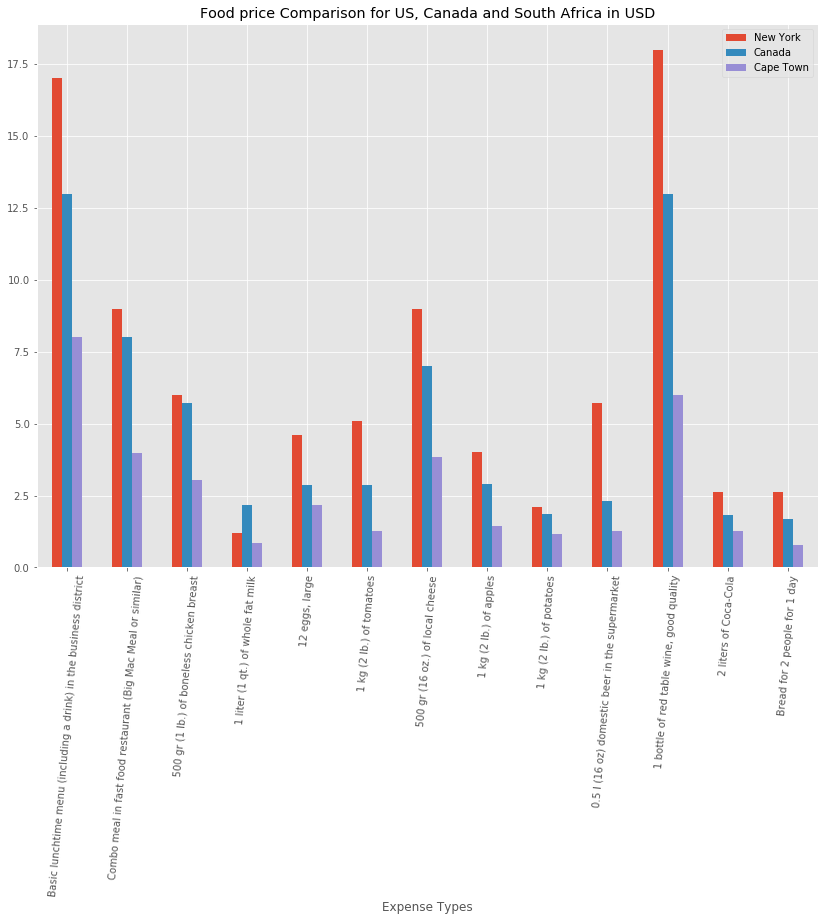

In [14]:
food_comp.plot(kind='bar', figsize=(14,10), rot=85)
plt.title('Food price Comparison for US, Canada and South Africa in USD')
plt.savefig('food_comp.jpg')

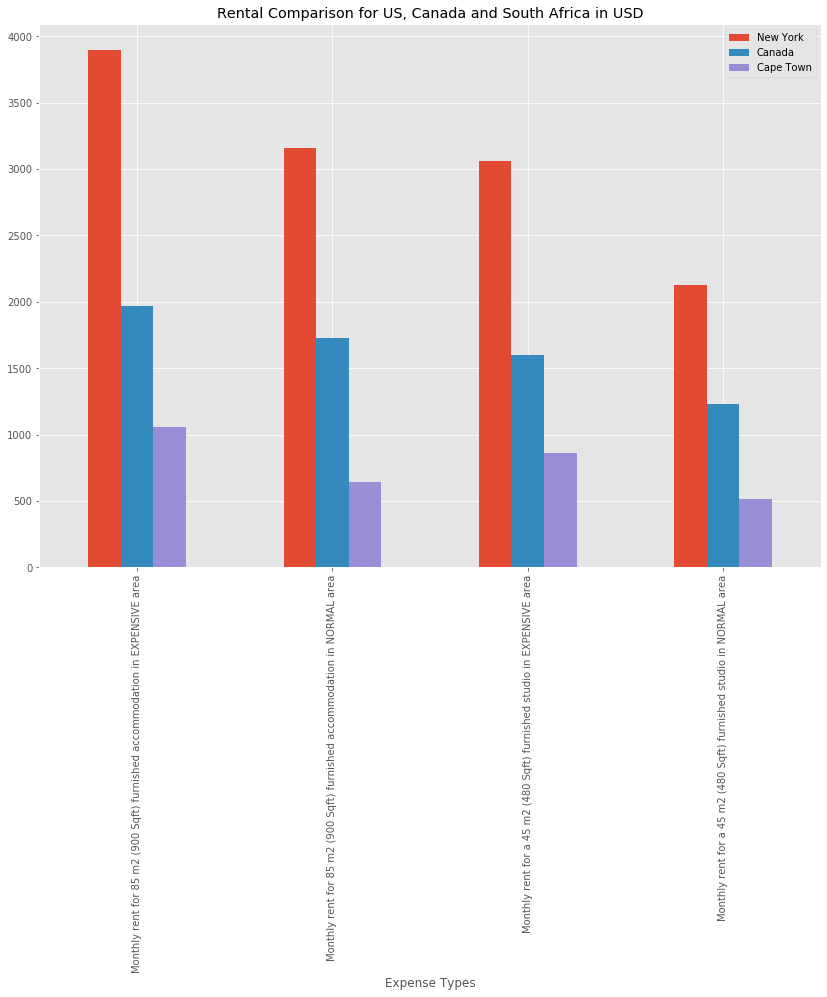

In [15]:
pd.DataFrame(housing_comp[0:2].append(housing_comp[3:5])).plot(kind='bar', figsize=(14,10))
plt.title('Rental Comparison for US, Canada and South Africa in USD')
plt.savefig('rental_comp.jpg')

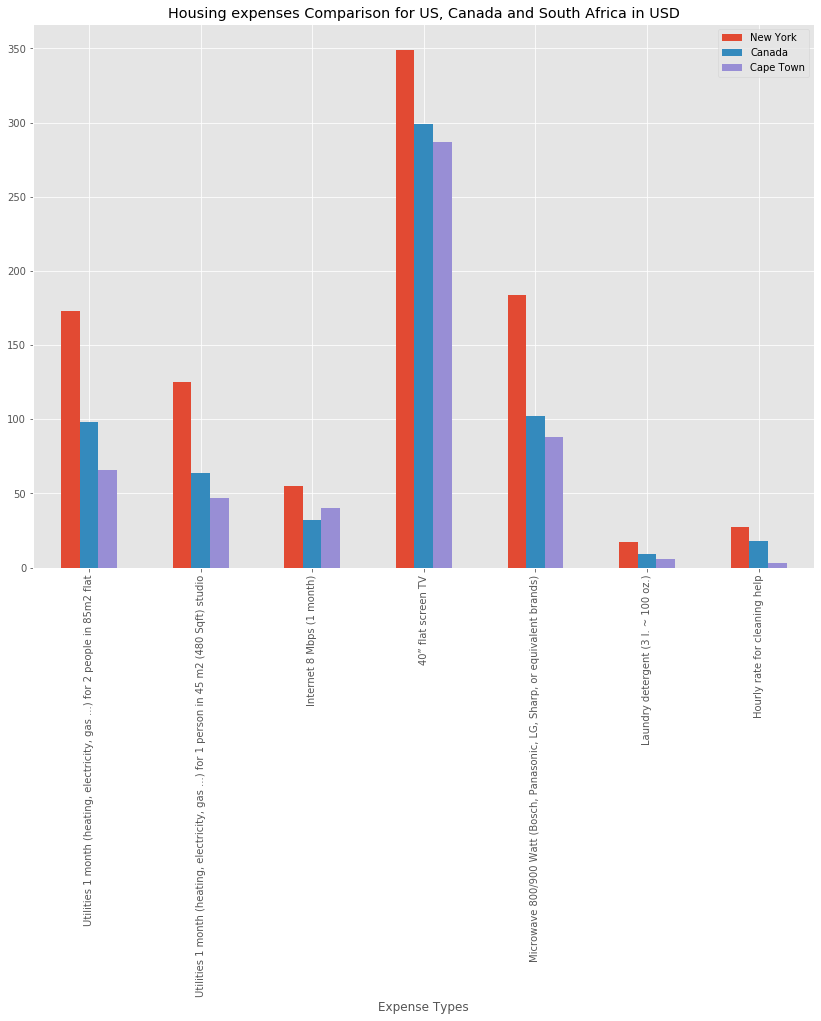

In [16]:
pd.DataFrame(housing_comp[2:3].append(housing_comp[5:])).plot(kind='bar', figsize=(14,10))
plt.title('Housing expenses Comparison for US, Canada and South Africa in USD')
plt.savefig('house_hold.jpg')

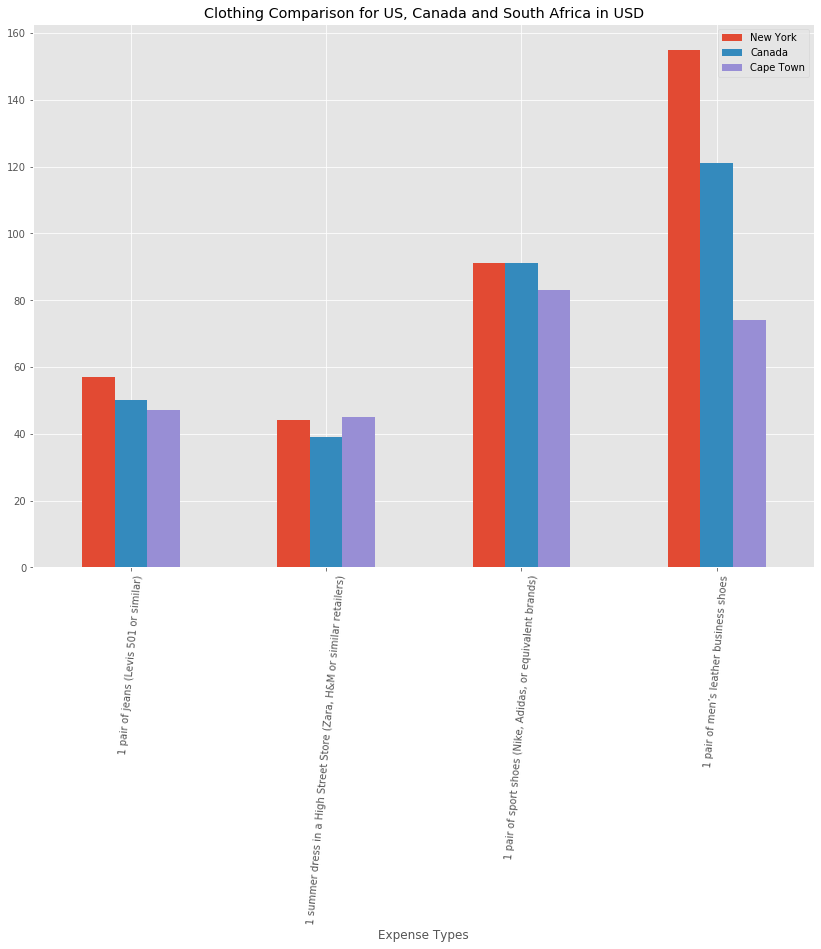

In [17]:
clothing_comp.plot(kind='bar', figsize=(14,10), rot=85)
plt.title('Clothing Comparison for US, Canada and South Africa in USD')
plt.savefig('clothing_comp.jpg')

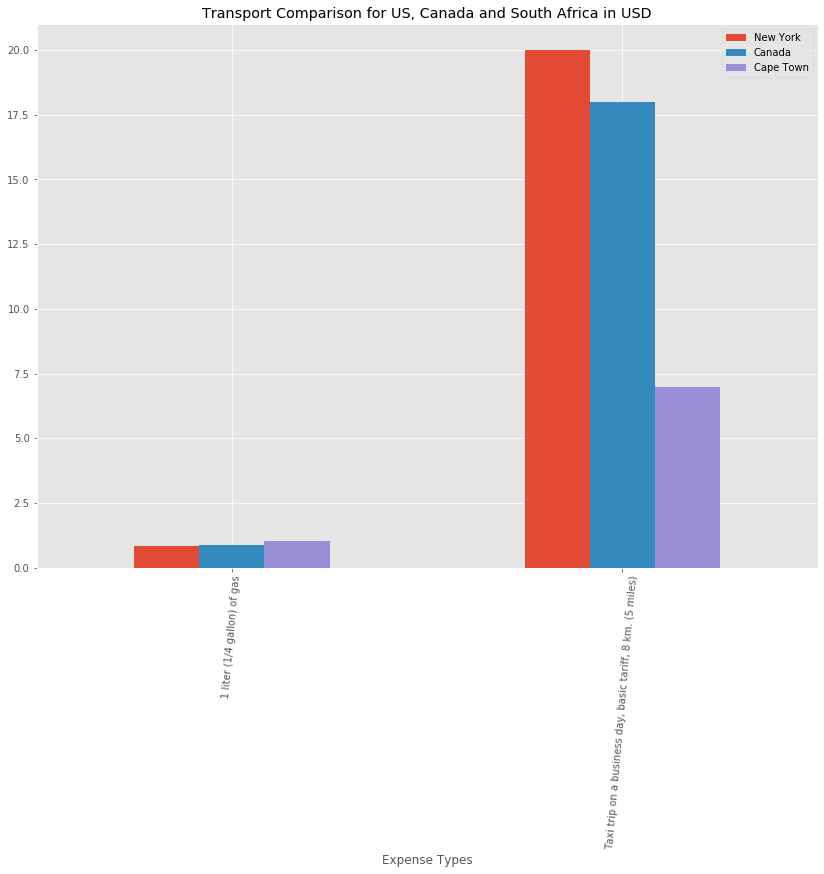

In [18]:
transport_comp[1::2].plot(kind='bar', figsize=(14,10), rot=85)
plt.title('Transport Comparison for US, Canada and South Africa in USD')
plt.savefig('transport_comp_1.jpg') # Interesting Fuel in South-Africa is more expensive, but the taxi trip are cheaper

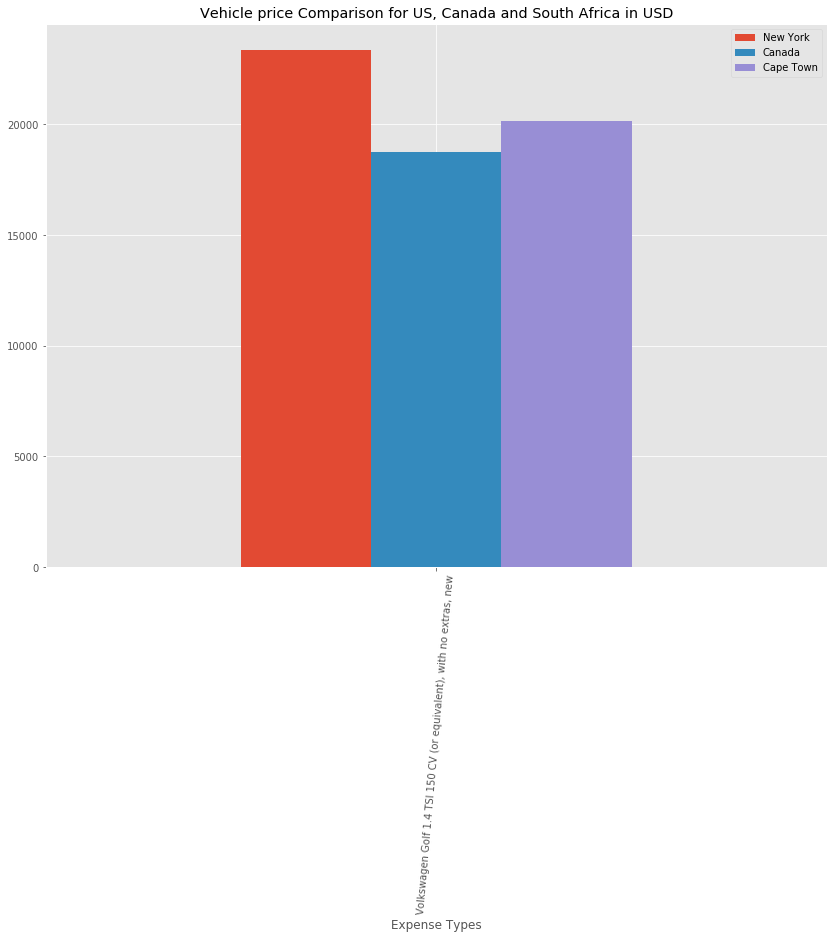

In [19]:
transport_comp[0:1].plot(kind='bar', figsize=(14,10), rot=85)
plt.title('Vehicle price Comparison for US, Canada and South Africa in USD')
plt.savefig('transport_comp_2.jpg') 

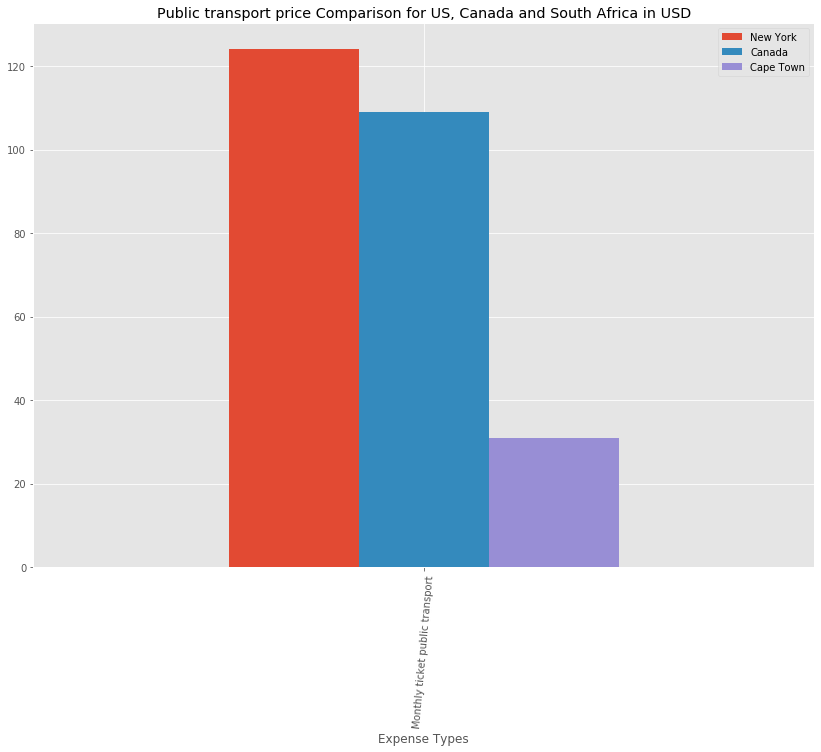

In [20]:
transport_comp[2:3].plot(kind='bar', figsize=(14,10), rot=85)
plt.title('Public transport price Comparison for US, Canada and South Africa in USD')
plt.savefig('transport_comp_3.jpg') # Still wondering about the fuel that is more expensive, yet public transport is also cheaper

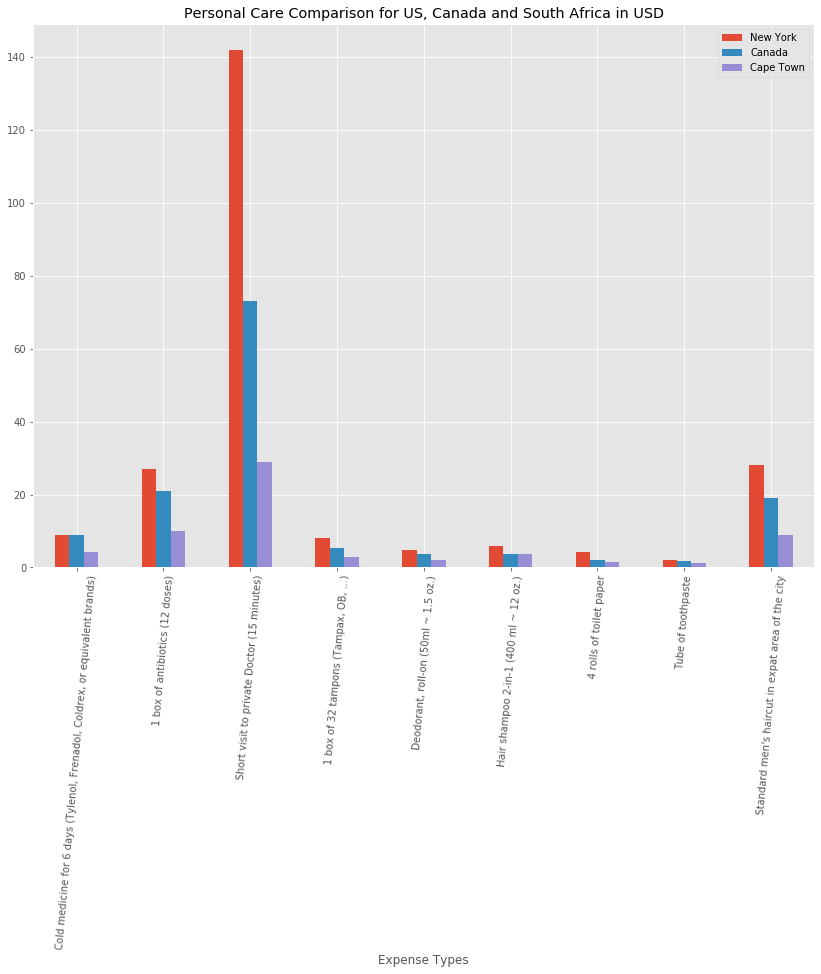

In [21]:
care_comp.plot(kind='bar', figsize=(14,10), rot=85)
plt.title('Personal Care Comparison for US, Canada and South Africa in USD')
plt.savefig('personal_care_comp.jpg') 

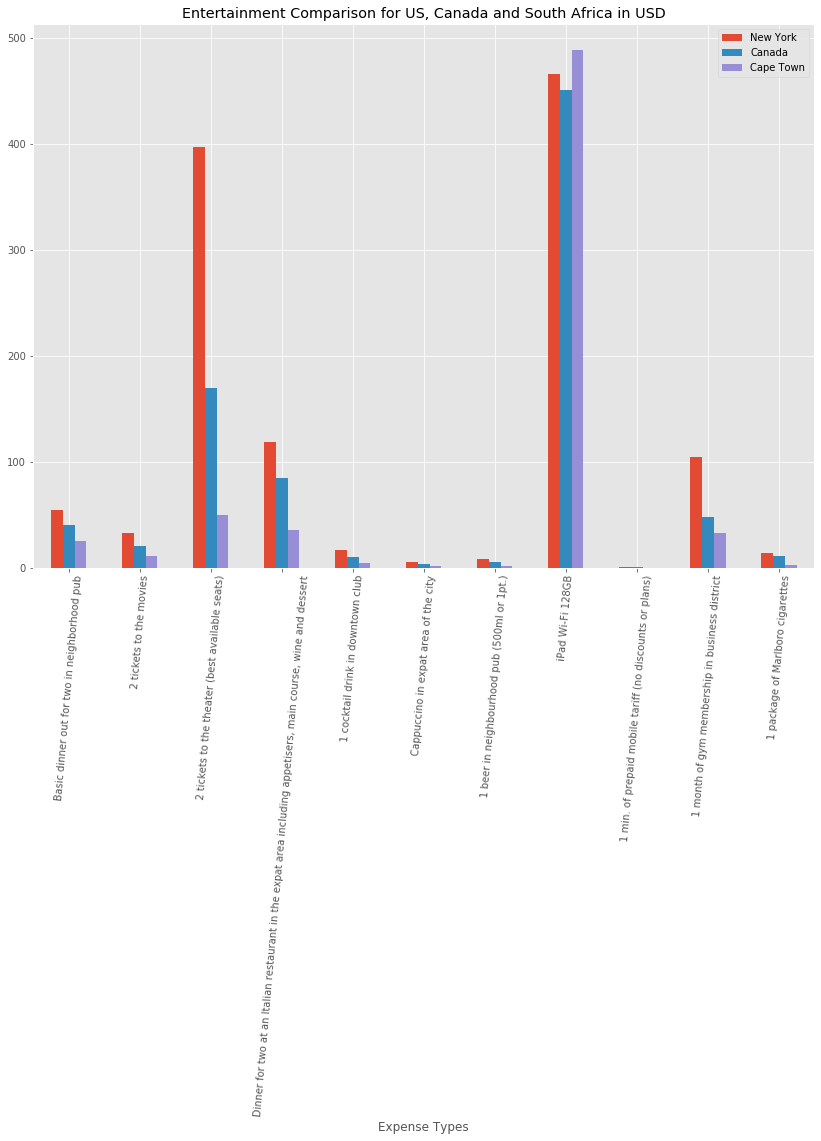

In [22]:
entertain_comp.plot(kind='bar', figsize=(14,10), rot=85)
plt.title('Entertainment Comparison for US, Canada and South Africa in USD')
plt.savefig('entertainment.jpg')

In [23]:
#Function to get the nearby venues
def getNearbyVenues(names, latitudes, longitudes, radius=5000, categoryids=[]):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        if len(categoryids) > 0:
            url = url + '&categoryId={}'.format(','.join(categoryids))
            
        # make the GET request
        results = get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        try:    
            venues_list.append([(
                name,
                lat,
                lng,
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])
        except:
            pass
    try:
        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = ['Neighbourhood', 'Latitude', 'Longitude',  
              'Venue', 
              'Venue Latitude', 
              'Venue Longitude', 
              'Venue Category']
    except:
        nearby_venues = pd.DataFrame(columns=['Neighbourhood', 'Latitude', 'Longitude'
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category'])

    
    return(nearby_venues)

In [24]:
CLIENT_ID = 'LH2OJQC5DUE5Y3TQZVD3DXDH2A3ASD5MANEVAKEMGDJN0HWT' # your Foursquare ID
CLIENT_SECRET = 'YRM0HCKVDAG5GJU1JYCKPMUWJD0IZUVF1N0ZY3GRKLC3MXT3' # your Foursquare Secret
VERSION = '20191005' # Foursquare API version
LIMIT = 500

In [25]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values (OpenStreetMaps)

def get_geo(address):
    address = address
    geolocator = Nominatim(user_agent="my-application")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return address, latitude, longitude


In [27]:
#So let us start exploring the different Neighbourhoods in Cape Town
# The below data has already been formatted in a different notebook called 'Cape_Town_Data' also available on gitub
cpt_neighbourhoods = pd.read_csv('cape_town_data.csv')
# We will only be using 'Borough', 'Neighbourhood', 'Latitude', 'Longitude' from the loaded data so other columns can be dropped
cpt_neighbourhoods.drop(cpt_neighbourhoods.columns[[0,1,6,7,8,9,10,11,12,13,14,15,16]], axis=1, inplace=True)
print('Cape Town has {} boroughs and {} neighbourhoods.'.format(
        len(cpt_neighbourhoods['Borough'].unique()),
        cpt_neighbourhoods.shape[0]
    )
)


Cape Town has 8 boroughs and 41 neighbourhoods.


In [160]:
# Categories = Trade Schools, Home services, Flea Markets and recyling
categories = ['4bf58dd8d48988d1ad941735', '545419b1498ea6ccd0202f58', '4bf58dd8d48988d1f7941735', '4f4531084b9074f6e4fb0101']
cpt_venues = getNearbyVenues(list(cpt_neighbourhoods['Neighbourhood']), 
                             list(cpt_neighbourhoods['Latitude']),
                             list(cpt_neighbourhoods['Longitude']),
                                  radius=1500,
                                  categoryids=categories)
cpt_venues.head()

Delft
Macassar
Firgrove, Somerset West
Gordon's Bay, Strand
Brooklyn, Kensington, Maitland, Rugby
Ndabeni, Pinelands
Bothasig, Edgemead
Bloubergstrand, Melkbosstrand, Milnerton, Montague Gardens, Parklands, Table View, West Beach
Langa
Epping
Goodwood, Monte Vista, Thornton
Belhar
Panorama, Parow, Plattekloof
Bellville, Loevenstein
Durbanville
Brackenfell
Kraaifontein
Kuils River
Milnerton
Mowbray, Newlands, Rondebosch, Rosebank
Bishopscourt, Claremont, Harfield Village, Kenilworth
Gugulethu, Nyanga, Philippi
Athlone, Bonteheuwel
Crawford
Kenwyn, Lansdowne, Rondebosch East
Khayelitsha
Mitchells Plain, Samora Machel
Strandfontein
Ottery
Plumstead, Wynberg
Hout Bay, Imizamo Yethu, Llandudno
Constantia, Kreupelbosch, Meadowridge
SouthField
Salt River, Walmer Estate (District Six), Woodstock (including Upper Woodstock), Zonnebloem (District Six)
Observatory
Grassy Park, Lotus River
Lavender Hill
Lakeside, Marina da Gama, Muizenberg, St James
Bergvliet, Diep River, Heathfield, Kirstenhof, R

,Neighbourhood,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Firgrove, Somerset West",-34.040539,18.455753,RSec,-34.048965,18.462051,Home Service
1,"Brooklyn, Kensington, Maitland, Rugby",-33.908889,18.479167,Milnerton Market,-33.899885,18.478646,Flea Market
2,"Brooklyn, Kensington, Maitland, Rugby",-33.908889,18.479167,Chubb Fire and Security Cape Town,-33.904057,18.477400,Home Service
3,"Brooklyn, Kensington, Maitland, Rugby",-33.908889,18.479167,Inhep Electronic Holdings (Pty) Ltd,-33.912567,18.487139,Home Service
4,"Brooklyn, Kensington, Maitland, Rugby",-33.908889,18.479167,Blinds Cape Town,-33.917153,18.474219,Home Service


In [161]:
print('There are {} unique categories.'.format(len(cpt_venues['Venue Category'].unique())))

There are 5 unique categories.


In [173]:
# one hot encoding
cpt_onehot = pd.get_dummies(cpt_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
cpt_onehot['Neighbourhood'] = cpt_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [cpt_onehot.columns[-1]] + list(cpt_onehot.columns[:-1])
cpt_onehot = cpt_onehot[fixed_columns]

cpt_onehot.head()

,Neighbourhood,Flea Market,Food Court,Home Service,Recycling Facility,Trade School
0,"Firgrove, Somerset West",0,0,1,0,0
1,"Brooklyn, Kensington, Maitland, Rugby",1,0,0,0,0
2,"Brooklyn, Kensington, Maitland, Rugby",0,0,1,0,0
3,"Brooklyn, Kensington, Maitland, Rugby",0,0,1,0,0
4,"Brooklyn, Kensington, Maitland, Rugby",0,0,1,0,0


In [174]:
#Function to sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [175]:
cpt_grouped = cpt_onehot.groupby('Neighbourhood').mean().reset_index()
cpt_grouped.shape

(29, 6)

In [176]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [177]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
cpt_venues_sorted = pd.DataFrame(columns=columns)
cpt_venues_sorted['Neighbourhood'] = cpt_grouped['Neighbourhood']

for ind in np.arange(cpt_grouped.shape[0]):
    cpt_venues_sorted.iloc[ind, 1:] = return_most_common_venues(cpt_grouped.iloc[ind, :], num_top_venues)

cpt_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,"Athlone, Bonteheuwel",Trade School,Recycling Facility,Home Service,Food Court,Flea Market
1,"Bellville, Loevenstein",Home Service,Trade School,Recycling Facility,Food Court,Flea Market
2,"Bergvliet, Diep River, Heathfield, Kirstenhof,...",Home Service,Trade School,Recycling Facility,Food Court,Flea Market
3,"Bloubergstrand, Melkbosstrand, Milnerton, Mont...",Home Service,Trade School,Recycling Facility,Food Court,Flea Market
4,Brackenfell,Home Service,Trade School,Recycling Facility,Food Court,Flea Market


In [178]:
# set number of clusters
kclusters = 10

cpt_grouped_clustering = cpt_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cpt_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([5, 0, 0, 0, 0, 8, 0, 3, 0, 6], dtype=int32)

In [179]:
# add clustering labels
cpt_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

cpt_merged = cpt_neighbourhoods

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
cpt_merged = cpt_merged.join(cpt_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

cpt_merged.head() # check the columns

,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Cape Flats,Delft,-33.965556,18.644444,NaN,NaN,NaN,NaN,NaN,NaN
1,Cape Flats,Macassar,-34.066116,18.767495,NaN,NaN,NaN,NaN,NaN,NaN
2,Helderberg,"Firgrove, Somerset West",-34.040539,18.455753,0.0,Home Service,Trade School,Recycling Facility,Food Court,Flea Market
3,Helderberg,"Gordon's Bay, Strand",-34.161125,18.868687,NaN,NaN,NaN,NaN,NaN,NaN
4,Northern Suburbs,"Brooklyn, Kensington, Maitland, Rugby",-33.908889,18.479167,8.0,Home Service,Flea Market,Trade School,Recycling Facility,Food Court


In [180]:
cpt_merged.loc[cpt_merged['Cluster Labels'] == 0]

,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
2,Helderberg,"Firgrove, Somerset West",-34.040539,18.455753,0.0,Home Service,Trade School,Recycling Facility,Food Court,Flea Market
7,West Coast,"Bloubergstrand, Melkbosstrand, Milnerton, Mont...",-33.797336,18.461023,0.0,Home Service,Trade School,Recycling Facility,Food Court,Flea Market
12,Northern Suburbs,"Panorama, Parow, Plattekloof",-33.879786,18.564810,0.0,Home Service,Trade School,Recycling Facility,Food Court,Flea Market
13,Northern Suburbs,"Bellville, Loevenstein",-33.898056,18.627778,0.0,Home Service,Trade School,Recycling Facility,Food Court,Flea Market
14,Northern Suburbs,Durbanville,-33.840278,18.649444,0.0,Home Service,Trade School,Recycling Facility,Food Court,Flea Market
15,Northern Suburbs,Brackenfell,-33.883056,18.700000,0.0,Home Service,Trade School,Recycling Facility,Food Court,Flea Market
29,Southern Suburbs,"Plumstead, Wynberg",-34.020000,18.477222,0.0,Home Service,Trade School,Recycling Facility,Food Court,Flea Market
30,Atlantic Seaboard,"Hout Bay, Imizamo Yethu, Llandudno",-34.043093,18.355645,0.0,Home Service,Trade School,Recycling Facility,Food Court,Flea Market
33,City Bowl,"Salt River, Walmer Estate (District Six), Wood...",-33.927943,18.477689,0.0,Home Service,Trade School,Recycling Facility,Food Court,Flea Market
35,Cape Flats,"Grassy Park, Lotus River",-34.045129,18.503253,0.0,Home Service,Trade School,Recycling Facility,Food Court,Flea Market


In [181]:
cpt_merged.loc[cpt_merged['Cluster Labels'] == 1]

,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
21,Cape Flats,"Gugulethu, Nyanga, Philippi",-33.982281,18.579578,1.0,Trade School,Home Service,Recycling Facility,Food Court,Flea Market
25,Cape Flats,Khayelitsha,-34.040591,18.667420,1.0,Trade School,Home Service,Recycling Facility,Food Court,Flea Market
32,Southern Suburbs,SouthField,-34.034722,18.483333,1.0,Trade School,Home Service,Recycling Facility,Food Court,Flea Market


In [182]:
cpt_merged.loc[cpt_merged['Cluster Labels'] == 2]

,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
37,South Peninsula,"Lakeside, Marina da Gama, Muizenberg, St James",-34.087222,18.456944,2.0,Food Court,Trade School,Recycling Facility,Home Service,Flea Market


In [42]:
cpt_merged.loc[cpt_merged['Cluster Labels'] == 3]

,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
6,Northern Suburbs,"Bothasig, Edgemead",-33.859444,18.541111,3,Home Service,Recycling Facility,Trade School,IT Services,Food Court,Flea Market,Fabric Shop,Distribution Center
8,Cape Flats,Langa,-33.945556,18.530000,3,Home Service,Recycling Facility,Trade School,IT Services,Food Court,Flea Market,Fabric Shop,Distribution Center
9,Cape Flats,Epping,-33.933369,18.534577,3,Home Service,Trade School,Recycling Facility,IT Services,Flea Market,Food Court,Fabric Shop,Distribution Center
10,Northern Suburbs,"Goodwood, Monte Vista, Thornton",-33.906667,18.549167,3,Home Service,Recycling Facility,Flea Market,Trade School,IT Services,Food Court,Fabric Shop,Distribution Center
11,Northern Suburbs,Belhar,-33.944722,18.625833,3,Home Service,Distribution Center,Trade School,Recycling Facility,IT Services,Food Court,Flea Market,Fabric Shop
12,Northern Suburbs,"Panorama, Parow, Plattekloof",-33.879786,18.564810,3,Home Service,Flea Market,Trade School,Recycling Facility,IT Services,Food Court,Fabric Shop,Distribution Center
13,Northern Suburbs,"Bellville, Loevenstein",-33.898056,18.627778,3,Home Service,Flea Market,Recycling Facility,Distribution Center,Trade School,IT Services,Food Court,Fabric Shop
20,Southern Suburbs,"Bishopscourt, Claremont, Harfield Village, Ken...",-33.988611,18.446667,3,Home Service,Recycling Facility,Fabric Shop,Trade School,IT Services,Food Court,Flea Market,Distribution Center
21,Cape Flats,"Gugulethu, Nyanga, Philippi",-33.982281,18.579578,3,Home Service,Trade School,Recycling Facility,IT Services,Food Court,Flea Market,Fabric Shop,Distribution Center
22,Cape Flats,"Athlone, Bonteheuwel",-33.966667,18.505000,3,Home Service,Recycling Facility,Trade School,IT Services,Food Court,Flea Market,Fabric Shop,Distribution Center


In [183]:
cpt_merged.loc[cpt_merged['Cluster Labels'] == 4]

,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
26,Cape Flats,"Mitchells Plain, Samora Machel",-34.050556,18.618056,4.0,Home Service,Flea Market,Trade School,Recycling Facility,Food Court
34,Southern Suburbs,Observatory,-33.936944,18.468333,4.0,Home Service,Flea Market,Trade School,Recycling Facility,Food Court


In [184]:
# create map of all the different clusters
address, latitude, longitude = get_geo('Cape Town, ZA')
cpt_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(cpt_merged['Latitude'], cpt_merged['Longitude'], cpt_merged['Neighbourhood'], cpt_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(cpt_clusters)

cpt_clusters.save('cpt_clusters.html')
cpt_clusters

TypeError: list indices must be integers or slices, not float

From the above map we can see that there are a lot of lightgreen clusters, and one outlaying cluster that does not fit the norm, Neighbour hoods in Cluster 1 and Cluster 3 seems to be choices for the project.

In [47]:
#Let us have another look at Cluster 1 and Cluster 3
cpt_cluster0 = cpt_merged.loc[cpt_merged['Cluster Labels'] == 0]
cpt_cluster3 = cpt_merged.loc[cpt_merged['Cluster Labels'] == 3]
cpt_cluster0.reset_index(inplace=True)
cpt_cluster3.reset_index(inplace=True)

#Build a list of points from dataframe that has the longitude and latitude
def build_points_list(df_lat_long):
    points = []
    for i in range(len(df_lat_long)):
        if i+1 != len(df_lat_long):
            points.append((df_lat_long[['Latitude', 'Longitude']].loc[i].Latitude, 
                          df_lat_long[['Latitude', 'Longitude']].loc[i].Longitude))
    return points


,index,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
11,31,Southern Suburbs,"Constantia, Kreupelbosch, Meadowridge",-34.028333,18.415556,0,Home Service,Trade School,Recycling Facility,IT Services,Food Court,Flea Market,Fabric Shop,Distribution Center
12,32,Southern Suburbs,SouthField,-34.034722,18.483333,0,Home Service,Food Court,Fabric Shop,Trade School,Recycling Facility,IT Services,Flea Market,Distribution Center
13,35,Cape Flats,"Grassy Park, Lotus River",-34.045129,18.503253,0,Home Service,Trade School,Recycling Facility,IT Services,Food Court,Flea Market,Fabric Shop,Distribution Center
14,38,Southern Suburbs,"Bergvliet, Diep River, Heathfield, Kirstenhof,...",-34.044796,18.452832,0,Home Service,Trade School,Food Court,Fabric Shop,Recycling Facility,IT Services,Flea Market,Distribution Center
15,39,South Peninsula,"Capri Village, Clovelly, Fish Hoek, Glencairn,...",-34.137766,18.432652,0,Home Service,Trade School,Recycling Facility,IT Services,Food Court,Flea Market,Fabric Shop,Distribution Center


In [48]:
# Function to draw points in the map
from scipy.spatial import ConvexHull
def draw_points(map_object, list_of_points, layer_name, line_color, fill_color, text):

    fg = folium.FeatureGroup(name=layer_name)

    for point in list_of_points:
        fg.add_child(folium.CircleMarker(point, radius=1, color=line_color, fill_color=fill_color,
                                         popup=(folium.Popup(text))))

    map_object.add_child(fg)

# Function that takes a map and a list of points (LON,LAT tupels) and
# returns a map with the convex hull polygon from the points as a new layer

def create_convexhull_polygon(map_object, list_of_points, layer_name, line_color, fill_color, weight, text): 

    # Since it is pointless to draw a convex hull polygon around less than 3 points check len of input
    if len(list_of_points) < 3:
        return

    # Create the convex hull using scipy.spatial 
    form = [list_of_points[i] for i in ConvexHull(list_of_points).vertices]

    # Create feature group, add the polygon and add the feature group to the map 
    fg = folium.FeatureGroup(name=layer_name)
    fg.add_child(folium.vector_layers.Polygon(locations=form, color=line_color, fill_color=fill_color,
                                              weight=weight, popup=(folium.Popup(text))))
    map_object.add_child(fg)

    return(map_object)


In [51]:
# Initialize map
cpt_convexhull_map = folium.Map(location=[latitude, longitude], zoom_start=10)

# Create a convex hull polygon that contains some points
#list_of_points = randome_points(amount=10, LON_min=48, LON_max=49, LAT_min=9, LAT_max=10)



create_convexhull_polygon(cpt_convexhull_map, build_points_list(cpt_cluster0), layer_name='Cluster0 Convex',
                        line_color='lightblue', fill_color='lightskyblue', weight=5, text='Cluster0') 

draw_points(cpt_convexhull_map, build_points_list(cpt_cluster0), layer_name='Cluster0 Points',
           line_color='royalblue', fill_color='royalblue', text='Cluster0 Points')

create_convexhull_polygon(cpt_convexhull_map, build_points_list(cpt_cluster3), layer_name='Cluster3 Convex',
                        line_color='indianred', fill_color='red', weight=5, text='Cluster3') 

draw_points(cpt_convexhull_map, build_points_list(cpt_cluster3), layer_name='Cluster3 Points',
           line_color='darkred', fill_color='darkred', text='Cluster 3 points')

# Add layer control and show map
folium.LayerControl(collapsed=False).add_to(cpt_convexhull_map)
cpt_convexhull_map.save('cpt_convex.html')
cpt_convexhull_map

From the above we can see that Cluster3 is the area where we should be looking at to setup the Trade school and the Pyrolysis plants

In [100]:
#Let us explore the venues in cluster3
cpt_cluster3_venues = pd.DataFrame(columns=cpt_venues.columns)
len(cpt_cluster3_venues)
for i in range(len(cpt_cluster3)):
    venue = cpt_venues.loc[cpt_venues.Neighbourhood == cpt_cluster3.Neighbourhood[i]]
    cpt_cluster3_venues = cpt_cluster3_venues.append(venue, ignore_index=True)
cpt_cluster3_venues

,Neighbourhood,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Bothasig, Edgemead",-33.859444,18.541111,Iron Horse Relocations - House Moving & Office...,-33.857266,18.522509,Home Service
1,"Bothasig, Edgemead",-33.859444,18.541111,4D Security Solutions,-33.861856,18.521001,Home Service
2,"Bothasig, Edgemead",-33.859444,18.541111,Drain Busters,-33.845089,18.522696,Home Service
3,"Bothasig, Edgemead",-33.859444,18.541111,Water Storage Cape Town (Pty) Ltd,-33.878682,18.554535,Home Service
4,"Bothasig, Edgemead",-33.859444,18.541111,Cape Town Waterproofing - Roof Contractors - R...,-33.879662,18.555353,Home Service
5,"Bothasig, Edgemead",-33.859444,18.541111,Potsdam Waste Water Treatment Plant,-33.839066,18.519049,Recycling Facility
6,"Bothasig, Edgemead",-33.859444,18.541111,PAC Electrical,-33.853504,18.507802,Home Service
7,"Bothasig, Edgemead",-33.859444,18.541111,Shutter Secure,-33.884311,18.560039,Home Service
8,"Bothasig, Edgemead",-33.859444,18.541111,MultiVision Technology (Pty) Ltd,-33.879588,18.507676,Home Service
9,"Bothasig, Edgemead",-33.859444,18.541111,Security Super Store,-33.893108,18.555145,Home Service


In [116]:
# We can now map the recycling facilities and the Trade Schools 
cpt_rec_sch = cpt_cluster3_venues[(cpt_cluster3_venues['Venue Category'] == 'Recycling Facility') |
                    (cpt_cluster3_venues['Venue Category'] == 'Trade School')]
cpt_rec_sch.groupby(cpt_cluster3_venues['Venue Latitude'])
cpt_rec_sch

,Neighbourhood,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
5,"Bothasig, Edgemead",-33.859444,18.541111,Potsdam Waste Water Treatment Plant,-33.839066,18.519049,Recycling Facility
10,"Bothasig, Edgemead",-33.859444,18.541111,"Northlink College, Wingfield Campus",-33.897141,18.536713,Trade School
12,"Bothasig, Edgemead",-33.859444,18.541111,Sunridge Metal Recycling,-33.817696,18.535530,Recycling Facility
13,Langa,-33.945556,18.530000,Recycle1st,-33.939242,18.530336,Recycling Facility
18,Langa,-33.945556,18.530000,Nampak Recycling,-33.931550,18.564849,Recycling Facility
19,Langa,-33.945556,18.530000,Capsicum Culinary Studio,-33.926792,18.496963,Trade School
25,Epping,-33.933369,18.534577,Recycle1st,-33.939242,18.530336,Recycling Facility
27,Epping,-33.933369,18.534577,Nampak Recycling,-33.931550,18.564849,Recycling Facility
31,Epping,-33.933369,18.534577,Capsicum Culinary Studio,-33.926792,18.496963,Trade School
33,Epping,-33.933369,18.534577,"Northlink College, Wingfield Campus",-33.897141,18.536713,Trade School
